<a href="https://colab.research.google.com/github/rmaacario/Fine-Tune-BERT-for-Text-Classification-with-TensorFlow/blob/main/Fine_Tune_BERT_for_Text_Classification_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

In this [project](https://www.coursera.org/projects/fine-tune-bert-tensorflow/), you will learn how to fine-tune a BERT model for text classification using TensorFlow and TF-Hub.

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

### Learning Objectives

By the time you complete this project, you will be able to:

- Build TensorFlow Input Pipelines for Text Data with the [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API
- Tokenize and Preprocess Text for BERT
- Fine-tune BERT for text classification with TensorFlow 2 and [TF Hub](https://tfhub.dev)

### Prerequisites

In order to be successful with this project, it is assumed you are:

- Competent in the Python programming language
- Familiar with deep learning for Natural Language Processing (NLP)
- Familiar with TensorFlow, and its Keras API

### Contents

This project/notebook consists of several Tasks.

- **[Task 1]()**: Introduction to the Project.
- **[Task 2]()**: Setup your TensorFlow and Colab Runtime
- **[Task 3]()**: Download and Import the Quora Insincere Questions Dataset
- **[Task 4]()**: Create tf.data.Datasets for Training and Evaluation
- **[Task 5]()**: Download a Pre-trained BERT Model from TensorFlow Hub
- **[Task 6]()**: Create a TensorFlow Input Pipeline with `tf.data`
- **[Task 7]()**: Add a Classification Head to the BERT `hub.KerasLayer`
- **[Task 8]()**: Fine-Tune BERT for Text Classification
- **[Task 9]()**: Evaluate the BERT Text Classification Model

## Task 2: Setup your TensorFlow and Colab Runtime.

You will only be able to use the Colab Notebook after you save it to your Google Drive folder. Click on the File menu and select “Save a copy in Drive…

![Copy to Drive](https://drive.google.com/uc?id=1CH3eDmuJL8WR0AP1r3UE6sOPuqq8_Wl7)


### Check GPU Availability

Check if your Colab notebook is configured to use Graphical Processing Units (GPUs). If zero GPUs are available, check if the Colab notebook is configured to use GPUs (Menu > Runtime > Change Runtime Type).

![Hardware Accelerator Settings](https://drive.google.com/uc?id=1qrihuuMtvzXJHiRV8M7RngbxFYipXKQx)


In [1]:
!nvidia-smi

Fri Apr  7 17:38:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [2]:
import tensorflow as tf
print(tf.version.VERSION)

2.12.0


In [ ]:
#!pip install -q tensorflow==2.3.0

In [3]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 505), reused 1389 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 16.89 MiB/s, done.
Resolving deltas: 100% (505/505), done.
Note: switching to '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

In [ ]:
!pip install tensorflow-text

## Restart the Runtime

**Note** 
After installing the required Python packages, you'll need to restart the Colab Runtime Engine (Menu > Runtime > Restart runtime...)

![Restart of the Colab Runtime Engine](https://drive.google.com/uc?id=1xnjAy2sxIymKhydkqb0RKzgVK9rh3teH)

## Task 3: Download and Import the Quora Insincere Questions Dataset

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
import tensorflow_text as text

In [4]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.12.0
Eager mode:  True
Hub version:  0.13.0
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', 
                 compression = 'zip', low_memory=False)
df.shape

(1306122, 3)

In [8]:
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

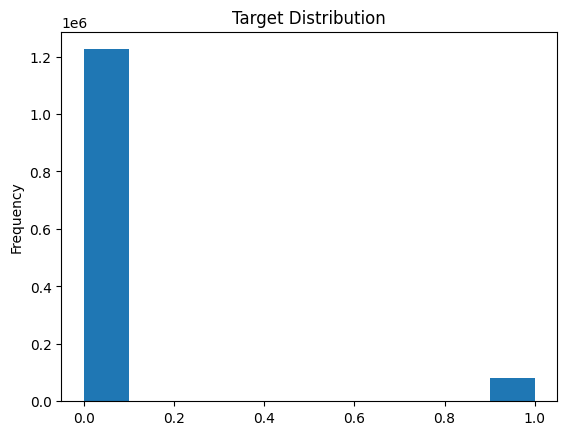

In [9]:
# target label distribution
df.target.plot(kind='hist', title="Target Distribution")

## Task 4: Create tf.data.Datasets for Training and Evaluation

Using a smaller subset of data is practical for finetuning large models like BERT. You can randomly sample or select a representative subset to reduce processing time and evaluate the model's performance. If successful, the model can then be trained on the full dataset.

In [10]:
train_df, remaining = train_test_split(df, random_state = 42, train_size = 0.0075, stratify = df['target'])
val_df, _ = train_test_split(remaining, random_state=42, train_size = 0.00075, stratify = remaining['target'])

print(train_df.shape, val_df.shape)

(9795, 3) (972, 3)


In [11]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  val_data = tf.data.Dataset.from_tensor_slices((val_df['question_text'].values, val_df['target'].values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Task 5: Download a Pre-trained BERT Model from TensorFlow Hub

In [13]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

# Label categories
label_list = [0, 1]

# maximum length of (token) input sequences
max_seq_length = 128  # default max length

train_batch_size = 32

In [18]:
# Get BERT layer and tokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

#tokenizer = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [19]:
# see an example of tokenization
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [21]:
# covert to IDs

tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

# Task 6: Tokenize and Preprocess Text for BERT

In [ ]:
bert_tokenizer = hub.load(tokenizer)

bert_tokenizer.tokenize(['hi, how are you doing?'])

<tf.RaggedTensor [[[7632], [1010], [2129], [2024], [2017], [2725], [1029]]]>

In [ ]:
# create keras layers to preprocess the text and encode to fit to the bert model

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'inputs')

# preprocessing
preprocessor = hub.KerasLayer(tokenizer)
encoder_inputs = preprocessor(text_input)

preprocess_model = tf.keras.Model(text_input, encoder_inputs)

preprocess_model(tf.constant(['hi, how are you doing?']))

{'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

## Task 8: Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = train_data.shuffle(1000).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)

  # valid
  val_data = val_data.batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)
  

In [ ]:
# train data spec
train_data.element_spec

(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

In [ ]:
# valid data spec
val_data.element_spec

(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

## Task 9: Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [ ]:
# Building the model
def create_model():
  
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'inputs')

  # preprocessing
  preprocessor = hub.KerasLayer(tokenizer)
  encoder_inputs = preprocessor(text_input)

  # passing the encoded inputs to bert model
  encoder = hub.KerasLayer(bert_layer, trainable=True, name = 'BERT_Encoder')
  outputs = encoder(encoder_inputs)

  # get the pooled outputs
  pooled_output = outputs['pooled_output']

  # add output layer
  batch_norm = tf.keras.layers.BatchNormalization()(pooled_output)
  drop = tf.keras.layers.Dropout(0.4)(batch_norm)
  fc = tf.keras.layers.Dense(128, activation='relu')(drop)
  final_output = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(fc)
    
  return tf.keras.Model(text_input, final_output)
  

## Task 10: Fine-Tune BERT for Text Classification

In [ ]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'input_word_ids': ( 0           inputs[0][0]                     
__________________________________________________________________________________________________
BERT_Encoder (KerasLayer)       {'pooled_output': (N 109482241   keras_layer_1[0][0]              
                                                                 keras_layer_1[0][1]              
                                                                 keras_layer_1[0][2]              
____________________________________________________________________________________________

In [ ]:
# Train model
epochs = 3
history = model.fit(train_data, 
                    validation_data=val_data,
                    epochs=epochs, 
                    verbose=1)

Epoch 1/3
306/306 [==============================] - 284s 877ms/step - loss: 0.5032 - binary_accuracy: 0.7270 - val_loss: 0.2437 - val_binary_accuracy: 0.9458
Epoch 2/3
306/306 [==============================] - 268s 875ms/step - loss: 0.1545 - binary_accuracy: 0.9449 - val_loss: 0.1435 - val_binary_accuracy: 0.9552
Epoch 3/3
306/306 [==============================] - 267s 873ms/step - loss: 0.1140 - binary_accuracy: 0.9590 - val_loss: 0.1483 - val_binary_accuracy: 0.9615


## Task 11: Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

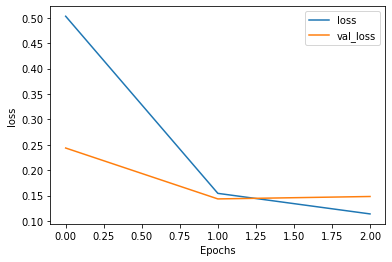

In [ ]:
plot_graphs(history=history, metric='loss')

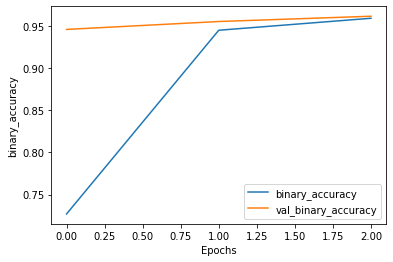

In [ ]:
plot_graphs(history,'binary_accuracy')

In [ ]:
# testing on some samples
sample_example = ["Do you have an adopted dog, how would you encourage people to adopt and not shop?"]
model.predict(sample_example)

array([[0.00047495]], dtype=float32)

In [ ]:
sample_example = ["HWhy do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?"]
model.predict(sample_example)

array([[0.7486439]], dtype=float32)